<a href="https://colab.research.google.com/github/Beno71/humpback-whale-classification/blob/master/Colab_siamese_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# siamese networks for whale classification

In [24]:
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os, time, itertools
from skimage import io, transform
import skimage
import glob
from tqdm import tnrange, tqdm
from collections import Counter
from random import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from IPython.display import clear_output

%matplotlib inline

# Load Data

In [26]:
# some prep steps
# for google colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
  
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  data_folder = "/content/drive/My Drive/Colab Notebooks/data/"
else:
  data_folder = "data/"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#load .npz-file from folder



loader = np.load(data_folder+"humpback_300x100_gray_no_new.npz")
features = loader["features"]
labels = loader["labels"]

n_rows = labels.shape[0]



split_ratio = 0.8
data_size = 500
expansion_factor = 8

#take the sample from the most common classes
ar = np.array(Counter(labels).most_common())
count = 0
label_list = []
for idx, tup in enumerate(ar):
    label_list.append(tup[0])
    count += tup[1]
    if count > data_size:
        break
label_list

label_in_list=[x in label_list for x in labels]
labels = labels[label_in_list]
features = features[label_in_list]

def standardize(X):
    X = X.astype(np.float32)
    X = (X - np.mean(X, axis=(1,2), keepdims=True)) / np.std(X, axis=(1,2), keepdims=True)
    return X

features = standardize(features)
features = np.expand_dims(features, axis=1)

all_combinations_without_labels = np.array(list(itertools.combinations(range(data_size),2)))
same_label_indices = labels[all_combinations_without_labels[:,0]] == labels[all_combinations_without_labels[:,1]]
all_combinations = np.append(all_combinations_without_labels, same_label_indices.reshape(-1,1), axis=1)

In [0]:
def train_test_split_old(split_ratio):
    """
    Get unique combinations from [0..data_size].
    Shuffle same_label_pairs and dif_label_pairs individually.
    Sample the first split_ratio*num pairs of each class for training and 
    sample the the rest (1-split_ratio)*num pairs of each class for validation
    
    """
    same_label_pairs = np.random.permutation(all_combinations[same_label_indices])
    dif_label_pairs = np.random.permutation(all_combinations[~same_label_indices])
    
    num_pairs = int(1/2*expansion_factor*data_size)
    num_train = int(split_ratio*num_pairs)
   
    train_matchings = np.append(same_label_pairs[:num_train], dif_label_pairs[:num_train], axis = 0)
    val_matchings = np.append(same_label_pairs[num_train:num_pairs], dif_label_pairs[num_train:num_pairs], axis = 0)
    
    np.random.shuffle(train_matchings), np.random.shuffle(val_matchings)
    
    return train_matchings.astype(int), val_matchings.astype(int)

In [0]:
def train_test_split(split_ratio):
    """
    First seperate all pictures into train_idx and val_idx. 
    Get unique combinations for each train_matchings and val_matchings.
    Shuffle same_label_pairs and dif_label_pairs individually.
    Sample the first split_ratio*num pairs of each class for training and 
    sample the the rest (1-split_ratio)*num pairs of each class for validation
    
    """
    perm = np.random.permutation(range(data_size))
    train_idx = perm[:int(split_ratio*data_size)]
    val_idx = perm[int(split_ratio*data_size):]
    
    def sample(idx, num_train):
        combinations = np.array(list(itertools.combinations(idx,2)))

        same_label_indices = labels[combinations[:,0]] == labels[combinations[:,1]]
        combinations = np.append(combinations, same_label_indices.reshape(-1,1), axis=1)

        same_label_pairs = np.random.permutation(combinations[same_label_indices])
        dif_label_pairs = np.random.permutation(combinations[~same_label_indices])
        
        matchings = np.append(same_label_pairs[:num_train], dif_label_pairs[:num_train], axis = 0)
        return matchings
    
    num_pairs = int(1/2*expansion_factor*data_size)
    train_matchings = sample(train_idx, num_train=int(split_ratio*num_pairs))
    val_matchings = sample(val_idx, num_train=int((1-split_ratio)*num_pairs))
    
    print("num train:", train_matchings.shape, "num val:", val_matchings.shape)
    
    np.random.shuffle(train_matchings), np.random.shuffle(val_matchings)
    return train_matchings.astype(int), val_matchings.astype(int)

### Train Test Split

In [30]:
train_matchings, val_matchings = train_test_split(split_ratio)

num train: (3200, 3) num val: (798, 3)


## Helper functions for calculation of accuracy

In [0]:
def get_unique_N(iterable, N):
    """Yields (in order) the first N unique elements of iterable. 
    Might yield less if data too short."""
    seen = set()
    for e in iterable:
        if e in seen:
            continue
        seen.add(e)
        yield e
        if len(seen) == N:
            return

In [0]:
def get_k_nearest(distance_matrix):
    dm = distance_matrix.copy()
    for i in range(dm.shape[0]):    
        dm[i,i] += 100000 
    nearest = np.empty(shape=(dm.shape[0], dm.shape[0]))
    for i in range(dm.shape[0]):
        nearest[:,i] = np.argmin(dm, axis=0)
        dm[nearest[:,i].astype(int)] += 100000
        nearest[:,i] = labels[nearest[:,i].astype(int)]
    top5_nearest = np.empty((distance_matrix.shape[0], 5))
    for idx, line in enumerate(nearest):
        #import pdb; pdb.set_trace()
        top5_nearest[idx,:] = np.fromiter(get_unique_N(line, 5), int)
    return top5_nearest.astype(int)

In [0]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs

# Check initializer of variables

In [0]:
class SiamN:
    
    def __init__(self, name, learning_rate=0.001):
        
        self.name = name
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.learning_rate = learning_rate
        self.weights =[]
        self.biases =[]
    
    def build(self, length=300, height=100, channels=1, margin=0.5):

        self.X_1 = tf.placeholder(shape=[None, channels, height, length], dtype=tf.float32, name="data_1") #[NxD]
        self.X_2 = tf.placeholder(shape=[None, channels, height, length], dtype=tf.float32, name="data_2")
        self.Y = tf.placeholder(shape=[None,], dtype=tf.float32, name="labels") #[Nx1]
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
        
            first_hidden = self.X_1
            first_conv1 = tf.layers.conv2d(inputs=first_hidden, filters=16, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            first_max_pool_1 = tf.layers.max_pooling2d(inputs=first_conv1, pool_size=2, strides=2, padding='same')
            first_conv2 = tf.layers.conv2d(inputs=first_max_pool_1, filters=32, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            first_max_pool_2 = tf.layers.max_pooling2d(inputs=first_conv2, pool_size=5, strides=2, padding='same')
            first_hidden = tf.contrib.layers.flatten(first_max_pool_2)
            first_hidden = tf.nn.dropout(first_hidden, 1-self.dropout)
            first_hidden = tf.contrib.layers.fully_connected(first_hidden, 20, activation_fn = None)

            self.outputs = first_hidden
            
            second_hidden = self.X_2
            second_conv1 = tf.layers.conv2d(inputs=second_hidden, filters=16, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            second_max_pool_1 = tf.layers.max_pooling2d(inputs=second_conv1, pool_size=2, strides=2, padding='same')
            second_conv2 = tf.layers.conv2d(inputs=second_max_pool_1, filters=32, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            second_max_pool_2 = tf.layers.max_pooling2d(inputs=second_conv2, pool_size=5, strides=2, padding='same')
            second_hidden = tf.contrib.layers.flatten(second_max_pool_2)
            second_hidden = tf.nn.dropout(second_hidden, 1-self.dropout)
            second_hidden = tf.contrib.layers.fully_connected(second_hidden, 20, activation_fn = None)
            
            
            self.distance = tf.norm(first_hidden - second_hidden)
            self.similarity = (1-self.Y) * tf.square(self.distance)                                           # keep the similar label (1) close to each other
            self.dissimilarity = self.Y * tf.square(tf.maximum((margin - self.distance), 0))        # give penalty to dissimilar label if the distance is bigger than margin
            self.loss = tf.reduce_mean((self.dissimilarity + self.similarity) / 2)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
            
        
    def train(self, features, train_matchings, val_matchings, epochs=20, dropout=0.0, batch_size=512):

        train_losses = []
        val_losses = []
        
        config = tf.ConfigProto()
        #config.gpu_options.allow_growth=True
        self.session = tf.Session(config=config)
        session = self.session
        
        session.run(tf.global_variables_initializer())

        tr_loss = session.run(self.loss, feed_dict={self.X_1: features[train_matchings[:,0]], self.X_2: features[train_matchings[:,1]], self.Y: train_matchings[:,2]})
        val_loss = session.run(self.loss, feed_dict={self.X_1: features[val_matchings[:,0]], self.X_2: features[val_matchings[:,1]], self.Y: val_matchings[:,2]})
        
        train_losses.append(tr_loss)            
        val_losses.append(val_loss)
        print(f"Epoch 0/{epochs} train_loss: {train_losses[-1]} val_loss: {val_losses[-1]}")


        for epoch in range(epochs):
            if (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs} train_loss: {train_losses[-1]} val_loss: {val_losses[-1]}")  
            for batch_ixs in batch_data(train_matchings.shape[0], batch_size):
                    _ = session.run( self.optimizer, feed_dict={self.X_1: features[train_matchings[batch_ixs,0]], self.X_2: features[train_matchings[batch_ixs,1]], self.Y: train_matchings[batch_ixs,2]})  
            tr_loss = session.run(self.loss, feed_dict={self.X_1: features[train_matchings[:,0]], self.X_2: features[train_matchings[:,1]], self.Y: train_matchings[:,2]})
            val_loss = session.run(self.loss, feed_dict={self.X_1: features[val_matchings[:,0]], self.X_2: features[val_matchings[:,1]], self.Y: val_matchings[:,2]})
            train_losses.append(round(tr_loss/train_matchings.shape[0], 7))
            val_losses.append(round(val_loss/val_matchings.shape[0], 7))

        
        
        self.hist={'train_loss': np.array(train_losses),
           'val_loss': np.array(val_losses), "epochs_trained": epoch}
        

In [0]:
model1.session.close()

NameError: name 'model1' is not defined

In [35]:
#You can change layer types and the number of neurons by changing the following variables.
t = time.time()
epochs = 50
batch_size = 256


model1 = SiamN("first_model", learning_rate = 0.001)
model1.build(margin=1)

model1.train(features, train_matchings, val_matchings, epochs, batch_size=batch_size)
print("Training finished in", time.time()-t,"s.")

Epoch 0/50 train_loss: 13189.9384765625 val_loss: 3360.881591796875
Epoch 5/50 train_loss: 0.0642902 val_loss: 0.0824092
Epoch 10/50 train_loss: 0.0257764 val_loss: 0.0473786
Epoch 15/50 train_loss: 0.0151791 val_loss: 0.0357648
Epoch 20/50 train_loss: 0.0101339 val_loss: 0.0293099
Epoch 25/50 train_loss: 0.0072794 val_loss: 0.0248053
Epoch 30/50 train_loss: 0.0054506 val_loss: 0.0216134
Epoch 35/50 train_loss: 0.0042579 val_loss: 0.0193315
Epoch 40/50 train_loss: 0.0034026 val_loss: 0.0174718
Epoch 45/50 train_loss: 0.0027931 val_loss: 0.0160195
Epoch 50/50 train_loss: 0.0023236 val_loss: 0.014882
Training finished in 63.895395040512085 s.


In [0]:
outputs = model1.session.run(model1.outputs, feed_dict = {model1.X_1:features})
distance_matrix = euclidean_distances(outputs)

In [16]:
labels.shape

(522,)

In [0]:
#import pdb; pdb.pm()
top5_nearest = get_k_nearest(distance_matrix)

In [0]:
true_labels = np.repeat(np.array([labels]), 5, axis=0).T

In [0]:
prediction_matrix = top5_nearest == true_labels
weights_standard = np.array([1, 0.8, 0.6, 0.4, 0.2])
weights_first = np.array([1,0,0,0,0])
weights_half = np.array([1,0.5,0.33,0.25,0.20])
scores_per_image = prediction_matrix@weights_standard
score = np.sum(scores_per_image)/scores_per_image.shape[0]

In [20]:
score

0.3524904214559387

same whales? False
Index:  2546
0.11641918


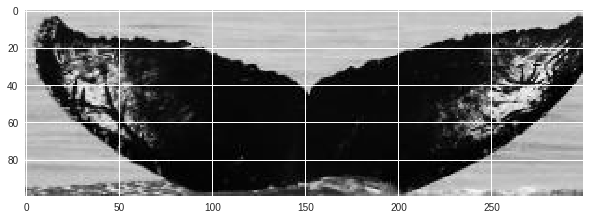

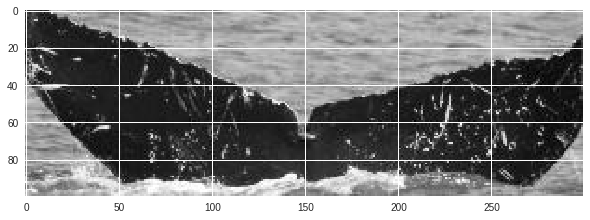

In [21]:
idx = np.random.randint(3200)
pic_a = features[train_matchings[idx,0]]
pic_b = features[train_matchings[idx,1]]
print(f"same whales? {bool(train_matchings[idx,2])}")    
print("Index: ", idx)
loss = model1.session.run(model1.distance, feed_dict={model1.X_1: np.array([pic_a]), model1.X_2: np.array([pic_b]), model1.Y: np.array([train_matchings[idx,2]])})
print(loss)
plt.figure(figsize=(10,5))
plt.imshow(pic_a[0], cmap="gray")
plt.figure(figsize=(10,5))
plt.imshow(pic_b[0], cmap="gray")

model 1


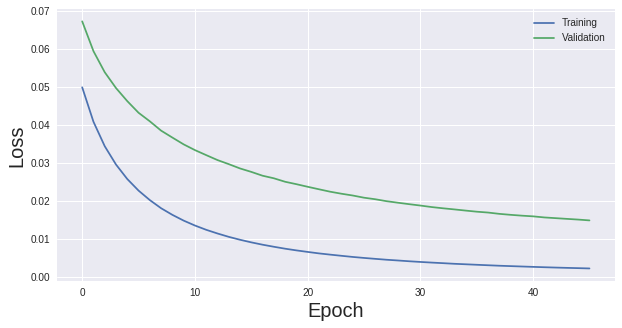

In [22]:

print("model 1")
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training")
plt.plot(model1.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

In [0]:
print(model1.hist["train_loss"])

[1.26482021e+04 3.41231000e-01 1.39892100e-01 7.28386000e-02
 5.03214000e-02 3.81109000e-02 3.04853000e-02 2.52421000e-02
 2.14250000e-02 1.84914000e-02 1.61852000e-02 1.43417000e-02
 1.27771000e-02 1.14885000e-02 1.03957000e-02 9.46010000e-03
 8.65060000e-03 7.94320000e-03 7.33660000e-03 6.78040000e-03
 6.28940000e-03 5.84760000e-03 5.45160000e-03 5.09750000e-03
 4.78840000e-03 4.50170000e-03 4.24090000e-03 4.00660000e-03
 3.79080000e-03 3.59050000e-03 3.40580000e-03 3.24050000e-03
 3.08260000e-03 2.93770000e-03 2.80490000e-03 2.68200000e-03
 2.55960000e-03 2.45260000e-03 2.34970000e-03 2.25320000e-03
 2.16190000e-03 2.07740000e-03 1.99620000e-03 1.91990000e-03
 1.84740000e-03 1.78120000e-03 1.71530000e-03 1.65450000e-03
 1.59680000e-03 1.54170000e-03 1.48960000e-03]


# Experimental: tensorflow datasets

In [0]:
train_data = tf.data.Dataset.from_tensor_slices({"feature": train_data, "label": train_labels})
val_data = tf.data.Dataset.from_tensor_slices({"feature": val_data, "label": val_labels})
train_data

In [0]:
train_data.output_types

In [0]:
#build batches
batch_size = 500
train_data.shuffle(30000)
batches = dataset.batch(batch_size)

In [0]:


sess = tf.Session()
iterator = batches.make_one_shot_iterator()
next_element = iterator.get_next()
no_of_batches = int(np.ceil(labels.shape[0] / batch_size))
counter = 1
for i in tqdm(range(no_of_batches)):
    value = sess.run(next_element)
    print(value["feature"].shape)
    print(counter)
    counter+=1

sess.close()